In [4]:
!pip install xgboost

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(
    "appl_accepted_20072019Q3.csv",
    low_memory=True,
    engine="c",
)

In [3]:
print('Dataset shape:', df.shape)

Dataset shape: (2650550, 150)


In [4]:
print('Top 5 columns:')

Top 5 columns:


In [5]:
pd.set_option('display.max_columns', None)   
pd.set_option('display.width', None)         
pd.set_option('display.max_colwidth', None)  

In [6]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68407277,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=68355089,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,Na

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2650550 entries, 0 to 2650549
Columns: 150 entries, id to settlement_term
dtypes: float64(111), object(39)
memory usage: 3.0+ GB


In [8]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,2.650517e+06,2.650517e+06,2.650517e+06,2.650517e+06,2.650513e+06,2.647892e+06,2.650488e+06,2.650517e+06,2.650517e+06,2.650487e+06,1.271577e+06,401333.000000,2.650488e+06,2.650488e+06,2.650517e+06,2.650488e+06,2.650517e+06,2.650517e+06,2.650517e+06,2.650517e+06,2.650517e+06,2.650517e+06,2.650517e+06,2.650517e+06,2.650517e+06,2.650517e+06,2.650517e+06,2.650517e+06,2.650372e+06,665345.000000,2650517.0,1.764640e+05,176460.000000,2.650488e+06,2.580241e+06,2.580241e+06,1.784387e+06,1.784388e+06,1.784388e+06,1.784388e+06,1.729804e+06,1.784388e+06,1.526423e+06,1.784388e+06,1.784388e+06,1.784388e+06,1.784076e+06,2.580241e+06,1.784388e+06,1.784387e+06,1.784387e+06,2.600487e+06,2.580146e+06,2.570873e+06,2.569549e+06,2.650372e+06,2.650488e+06,2.500657e+06,2.580240e+06,2.580240e+06,2.580241e+06,2.600487e+06,2.572638e+06,596550.000000,2.307243e+06,852593.000000,2.580241e+06,2.580241e+06,2.580241e+06,2.591927e+06,2.580241e+06,2.580241e+06,2.580241e+06,2.580240e+06,2.580241e+06,2.591927e+06,2.490475e+06,2.580241e+06,2.580241e+06,2.580241e+06,2.580086e+06,2.570396e+06,2.649152e+06,2.650412e+06,2.580241e+06,2.600487e+06,2.600487e+06,2.580241e+06,1.637740e+05,163775.000000,163775.000000,163775.000000,163775.000000,163775.000000,161040.000000,163775.000000,163775.000000,163775.000000,163775.000000,52853.000000,11061.0,11061.000000,11061.0,11061.000000,8783.000000,11061.000000,11061.000000,34555.000000,34555.000000,34555.000000
mean,NaN,1.526571e+04,1.526122e+04,1.524532e+04,4.503969e+02,7.907683e+04,1.909430e+01,2.961149e-01,6.998246e+02,7.038248e+02,5.572429e-01,3.481582e+01,73.903240,1.163815e+01,1.845853e-01,1.681476e+04,2.402934e+01,5.458909e+03,5.457889e+03,1.100907e+04,1.099344e+04,8.636420e+03,2.247759e+03,1.370043e+00,1.235199e+02,2.058230e+01,3.153101e+03,6.909028e+02,6.798003e+02,1.793069e-02,44.454267,1.0,1.283955e+05,19.292844,3.537839e-03,2.230998e+02,1.441106e+05,9.248902e-01,2.799994e+00,6.870288e-01,1.579734e+00,2.085128e+01,3.617570e+04,6.901857e+01,1.265937e+00,2.682590e+00,5.927627e+03,5.651313e+01,3.558821e+04,1.043681e+00,1.498918e+00,2.001306e+00,4.495804e+00,1.365708e+04,1.214305e+04,5.665340e+0

In [9]:
cols_to_drop = ['id', 'member_id', 'url', 'zip_code', 'addr_state', 'emp_title', 'desc', 'title']
for col in cols_to_drop:
    if col in df:
        df.drop(columns=col, inplace=True)

In [10]:
missing_counts = df.isnull().sum().sort_values(ascending=False)
print("Top missing values:\n", missing_counts.head(50))

Top missing values:
 orig_projected_additional_accrued_interest    2641767
hardship_status                               2639489
hardship_length                               2639489
hardship_dpd                                  2639489
hardship_last_payment_amount                  2639489
hardship_amount                               2639489
hardship_reason                               2639489
deferral_term                                 2639489
payment_plan_start_date                       2639489
hardship_type                                 2639489
hardship_loan_status                          2639489
hardship_payoff_balance_amount                2639489
hardship_end_date                             2639489
hardship_start_date                           2639489
settlement_percentage                         2615995
settlement_amount                             2615995
settlement_term                               2615995
settlement_date                               2615995
debt_se

In [11]:
cols_to_drop = [
    "orig_projected_additional_accrued_interest",
    "hardship_status",
    "hardship_length",
    "hardship_dpd",
    "hardship_last_payment_amount",
    "hardship_amount",
    "hardship_reason",
    "deferral_term",
    "payment_plan_start_date",
    "hardship_type",
    "hardship_loan_status",
    "hardship_payoff_balance_amount",
    "hardship_end_date",
    "hardship_start_date",
    "settlement_percentage",
    "settlement_amount",
    "settlement_term",
    "settlement_date",
    "debt_settlement_flag_date",
    "settlement_status",
    "sec_app_mths_since_last_major_derog",
    "sec_app_revol_util",
    "revol_bal_joint",
    "sec_app_collections_12_mths_ex_med",
    "sec_app_fico_range_low",
    "sec_app_inq_last_6mths",
    "sec_app_num_rev_accts",
    "sec_app_fico_range_high",
    "sec_app_mort_acc",
    "sec_app_open_acc",
    "sec_app_open_act_il",
    "sec_app_chargeoff_within_12_mths",
    "sec_app_earliest_cr_line",
    "verification_status_joint",
    "dti_joint",
    "annual_inc_joint",
    "mths_since_last_record",
    "mths_since_recent_bc_dlq",
    "mths_since_last_major_derog",
    "mths_since_recent_revol_delinq"
]

df = df.drop(columns=cols_to_drop, errors='ignore')

In [12]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

num_imp = SimpleImputer(strategy='median')
df[numeric_cols] = num_imp.fit_transform(df[numeric_cols])

cat_imp = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = cat_imp.fit_transform(df[categorical_cols])

In [13]:
print("Any nulls lefft?", df.isnull().any().any())

Any nulls lefft? False


In [14]:
risk_map = {
    'A': 'Low', 'B': 'Low', 'C': 'Low',
    'D': 'Medium', 'E': 'Medium',
    'F': 'High', 'G': 'High'
}

df['RiskLevel'] = df['grade'].map(risk_map)

for col in ['grade', 'sub_grade', 'loan_status']:
    if col  in df.columns:
        df.drop(columns=col, inplace=True)

In [15]:
print("RiskLevel distribution:\n", df['RiskLevel'].value_counts())

RiskLevel distribution:
 RiskLevel
Low       2078308
Medium     518221
High        54021
Name: count, dtype: int64


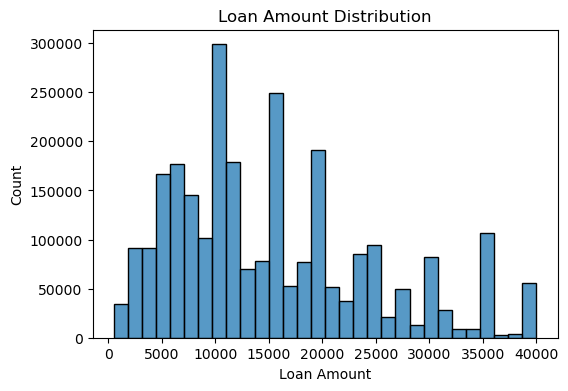

In [16]:
plt.figure(figsize=(6,4))
sns.histplot(df['loan_amnt'], bins=30, kde=False)
plt.title('Loan Amount Distribution')
plt.xlabel('Loan Amount')
plt.ylabel('Count')
plt.show()

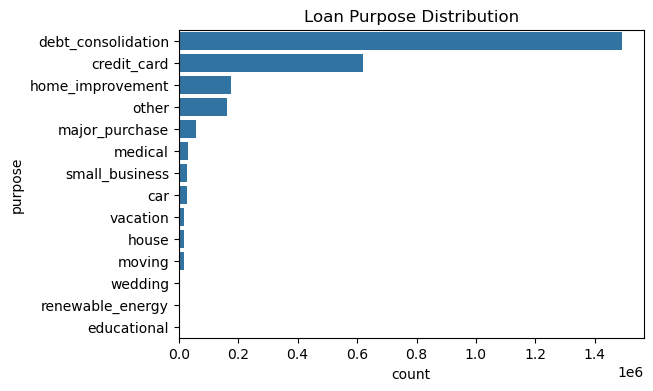

In [17]:
plt.figure(figsize=(6,4))
sns.countplot(y='purpose', data = df, order=df['purpose'].value_counts().index)
plt.title('Loan Purpose Distribution')
plt.ylabel('purpose')
plt.show()

In [18]:
df['int_rate'] = df['int_rate'].str.replace('%', '', regex=False).astype(float)

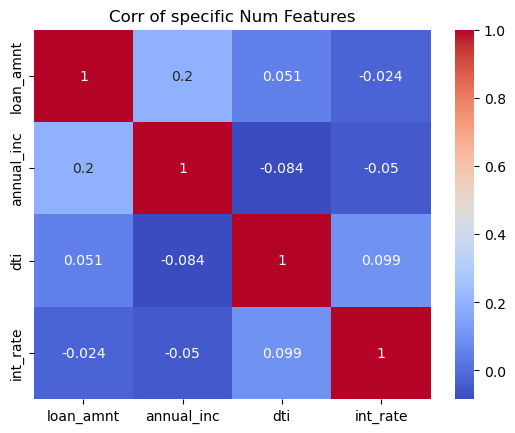

In [19]:
num_to_plot = ['loan_amnt', 'annual_inc', 'dti', 'int_rate']
corr = df[num_to_plot].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Corr of specific Num Features')
plt.show()

In [20]:
df['revol_util'].value_counts(dropna=False)

revol_util
0.0        15379
57.0        4322
48.0        4280
59.0        4265
61.0        4217
           ...  
107%           1
129%           1
108.90%        1
127.50%        1
109.80%        1
Name: count, Length: 3479, dtype: int64

In [45]:
if 'revol_util' in df.columns:
    df['revol_util'] = (
        df['revol_util']
        .astype(str)
        .str.replace('%', '', regex=False)
        .replace(['nan', 'None', ''], np.nan)
    )
    df['revol_util'] = pd.to_numeric(df['revol_util'], errors='coerce')
    print('revol_util cleaned. Nulls after cleaning:', df['revol_util'].isna().sum())
else:
    print('Column revol_util not found in dataframe')

revol_util cleaned. Nulls after cleaning: 0


In [46]:
df['revol_util'] = (
    df['revol_util']
    .astype(str)                     
    .str.replace('%', '', regex=False)
)

df['revol_util'] = pd.to_numeric(df['revol_util'], errors='coerce')

In [47]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

target = 'RiskLevel'
num_cols = [col for col in num_cols if col != target]
cat_cols = [col for col in cat_cols if col != target]

print('Numeric columns (sample):', num_cols[:10])
print('Categorical columns (sample):', cat_cols[:10])

Numeric columns (sample): ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high']
Categorical columns (sample): ['term', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d']


In [48]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'RiskLevel' in categorical_cols:
    categorical_cols.remove('RiskLevel')
if 'RiskLevel' in numeric_cols:
    numeric_cols.remove('RiskLevel')

categorical_cols, numeric_cols

(['term',
  'emp_length',
  'home_ownership',
  'verification_status',
  'issue_d',
  'pymnt_plan',
  'purpose',
  'earliest_cr_line',
  'initial_list_status',
  'last_pymnt_d',
  'next_pymnt_d',
  'last_credit_pull_d',
  'application_type',
  'hardship_flag',
  'debt_settlement_flag'],
 ['loan_amnt',
  'funded_amnt',
  'funded_amnt_inv',
  'int_rate',
  'installment',
  'annual_inc',
  'dti',
  'delinq_2yrs',
  'fico_range_low',
  'fico_range_high',
  'inq_last_6mths',
  'mths_since_last_delinq',
  'open_acc',
  'pub_rec',
  'revol_bal',
  'revol_util',
  'total_acc',
  'out_prncp',
  'out_prncp_inv',
  'total_pymnt',
  'total_pymnt_inv',
  'total_rec_prncp',
  'total_rec_int',
  'total_rec_late_fee',
  'recoveries',
  'collection_recovery_fee',
  'last_pymnt_amnt',
  'last_fico_range_high',
  'last_fico_range_low',
  'collections_12_mths_ex_med',
  'policy_code',
  'acc_now_delinq',
  'tot_coll_amt',
  'tot_cur_bal',
  'open_acc_6m',
  'open_act_il',
  'open_il_12m',
  'open_il_24m',

In [49]:
for col in cat_cols:
    types = df[col].apply(lambda x: type(x)).value_counts()
    if len(types) > 1:
        print('⚠ Mixed types in:', col, types)

print('\nDone checking mixed types.')


Done checking mixed types.


In [33]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

print('Preprocessor created with {} numeric and {} categorical columns'.format(len(num_cols), len(cat_cols)))

Preprocessor created with 84 numeric and 15 categorical columns


In [44]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

target = 'RiskLevel'
num_cols = [col for col in num_cols if col != target]
cat_cols = [col for col in cat_cols if col != target]

preprocessor =  ColumnTransformer(transformers=[
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
],
                                  sparse_threshold=1.0
                                 )

In [27]:
pipeline_placeholder = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', StandardScaler())
])

In [30]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['RiskLevel'] = le.fit_transform(df['RiskLevel'])
print("Encoded classes:", le.classes_)

X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train/Test class counts:\n", y_train.value_counts(), y_test.value_counts())

Encoded classes: ['High' 'Low' 'Medium']
Train/Test class counts:
 RiskLevel
1    1662646
2     414577
0      43217
Name: count, dtype: int64 RiskLevel
1    415662
2    103644
0     10804
Name: count, dtype: int64


In [34]:
pipe_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

pipe_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),  # fixed name
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42,
                         n_estimators=200, max_depth=6, learning_rate=0.1,
                         subsample=0.8, colsample_bytree=0.8, tree_method='hist'))
])

print('Pipelines ready (RandomForest and XGBoost).')

Pipelines ready (RandomForest and XGBoost).


pipe_rf.fit(X_train, y_train)
pipe_xgb.fit(X_train, y_train)

In [43]:
models  = {'Random Forest': pipe_rf, 'XGBoost': pipe_xgb}
for name, model in models.items():
    preds = model.predict(X_test)
    print(f"=== {name} Classification Report ===")
    print(classification_report(y_test, preds))
    
    f1 = f1_score(y_test, preds, average='macro')
    print(f"Macro F1 Score: {f1:.3f}\n")
    
    cm = confusion_matrix(y_test, preds, labels=[0, 1, 2])
    print(f"Confusion Matrix (rows=Actual, cols=Predicted) for {name}:\n{cm}\n")

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.02      0.04     10804
           1       0.87      0.99      0.92    415662
           2       0.77      0.41      0.54    103644

    accuracy                           0.86    530110
   macro avg       0.87      0.47      0.50    530110
weighted avg       0.85      0.86      0.83    530110

Macro F1 Score: 0.499

Confusion Matrix (rows=Actual, cols=Predicted) for Random Forest:
[[   209   2418   8177]
 [     0 410737   4925]
 [     7  60819  42818]]

=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.58      0.71     10804
           1       0.96      0.99      0.98    415662
           2       0.91      0.84      0.87    103644

    accuracy                           0.95    530110
   macro avg       0.93      0.80      0.85    530110
weighted avg       0.95      0.95      0.95    5

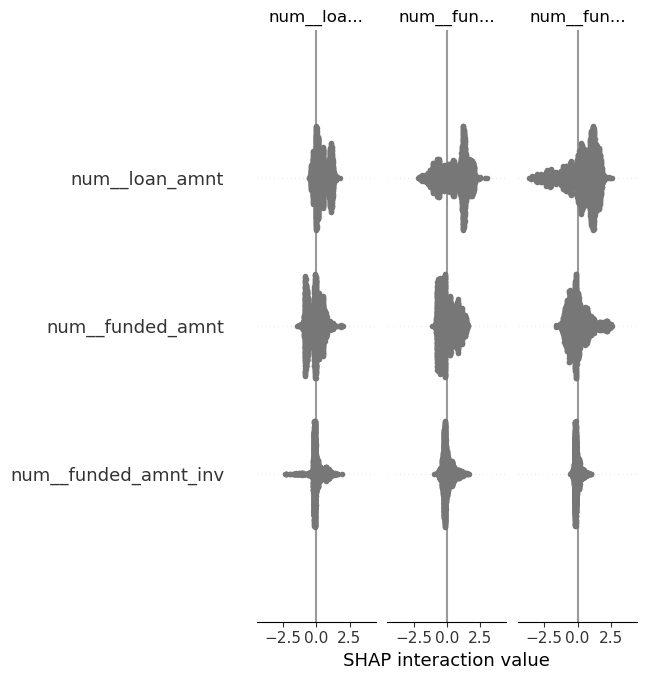

In [41]:
import shap
import numpy as np

model = pipe_xgb.named_steps['clf']

X_train_trans = pipe_xgb.named_steps['preprocessor'].transform(X_train)

sample_size = 3000   # you can increase to 5000 if RAM allows
idx = np.random.choice(X_train_trans.shape[0], sample_size, replace=False)

X_sample = X_train_trans[idx]

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_sample)

shap.summary_plot(
    shap_values,
    features=X_sample,
    feature_names=pipe_xgb.named_steps['preprocessor'].get_feature_names_out()
)

In [40]:
import joblib
joblib.dump(pipe_xgb, 'credit_scoring_rf.pkl')

['credit_scoring_rf.pkl']